In [1]:
import os
import pandas as pd
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import datetime
import pytz
import seaborn as sns

from utils import stats

In [2]:
from dask.diagnostics import ProgressBar
ProgressBar().register()

In [3]:
usa_path = "C:/Users/KatharinaG/Documents/USA"

In [4]:
col_refuel7 = sns.color_palette(["#c72321","#861719","#f0c320","#af8f19","#6e9b9e","#0d8085","#19484c"])
col_refuel3 = sns.color_palette(["#c72321", "#0d8085", "#efc220"])
col_refuel5 = sns.color_palette(["#c62220", "#fbd7a8", "#7a6952", "#0d8085", "#f0c220"])
col_refuel10 = sns.color_palette(["#c72321","#861719","#fbd7a9","#ba9f7c","#7a6952","#6e9b9e","#0d8085","#19484c","#f0c320","#af8f19"])
# select 5 colours for plotting of which 2 twice match
col_rf = [col_refuel7[i] for i in [0,1,2,3,5]]

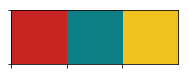

In [5]:
sns.palplot(col_refuel3)

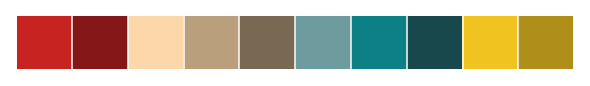

In [759]:
sns.palplot(col_refuel10)

# USA monthly

### Load production data
Source: https://www.eia.gov/electricity/data/browser/#/topic/0?agg=1,0,2&fuel=008&geo=vvvvvvvvvvvvo&sec=o3g&linechart=ELEC.GEN.WND-US-99.M~ELEC.GEN.WND-IA-99.M~ELEC.GEN.WND-TX-99.M&columnchart=ELEC.GEN.WND-US-99.M~ELEC.GEN.WND-IA-99.M~ELEC.GEN.WND-TX-99.M&map=ELEC.GEN.WND-US-99.M&freq=M&start=200101&end=201903&chartindexed=0&ctype=linechart&ltype=pin&rtype=s&pin=&rse=0&maptype=0

In [760]:
prod_USAm = pd.read_csv(usa_path+"/generation_data/USA_monthly/Net_generation_wind_all_sectors_monthly.csv",header=4)

arrange data

In [761]:
# rename columns
prod_USAm.columns = ['time','wp_obs','Iowa','Texas']

# sort indices
prod_USAm = prod_USAm[~np.isnan(prod_USAm.wp_obs)].sort_index(axis=0 ,ascending=False)

# create datetime index
months = pd.DataFrame({'month':range(1,13)},
                       index = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
prod_USAm['month'] = pd.Series([t[:3] for t in prod_USAm.time]).map(months.month).values
prod_USAm['year'] = [t[-4:] for t in prod_USAm.time]
prod_USAm = prod_USAm.set_index(pd.Index([np.datetime64(str(int(prod_USAm.year.values[i]))+"-"+f"{prod_USAm.month.values[i]:02d}"+"-01T00:00:00") for i in range(len(prod_USAm))])).drop(['time','month','year'],axis=1)

# cut after 2018
prod_USAm = prod_USAm[prod_USAm.index < np.datetime64("2019-01-01")]

### Prepare simulated data

In [780]:
# load data
wpE = xr.open_dataset(usa_path+"/results/windpower_USA_ERA5.nc").to_dataframe()
wpE_GWA = xr.open_dataset(usa_path+"/results/windpower_USA_ERA5_GWA.nc").to_dataframe()
wpM = xr.open_dataset(usa_path+"/results/windpower_USA_MERRA2.nc").to_dataframe()
wpM_GWA = xr.open_dataset(usa_path+"/results/windpower_USA_MERRA2_GWA.nc").to_dataframe()

# merge data
wp_USA = pd.concat([wpE,wpE_GWA,wpM,wpM_GWA],axis=1)
wp_USA.columns = ['ERA5','ERA5_GWA','MERRA2','MERRA2_GWA']

# sum up monthly
wp_USA['yearmonth'] = wp_USA.index.values.astype('datetime64[M]')
wp_USAm = wp_USA.groupby('yearmonth').sum()
# kW -> GW
wp_USAm = wp_USAm/10**6

### Combine data and analyse

In [781]:
comp_USAm = pd.concat([wp_USAm,prod_USAm.wp_obs],axis=1)

In [782]:
stats_USAm = pd.DataFrame({'ERA5':stats(comp_USAm.ERA5,comp_USAm.wp_obs),
                           'ERA5_GWA':stats(comp_USAm.ERA5_GWA,comp_USAm.wp_obs),
                           'MERRA2':stats(comp_USAm.MERRA2,comp_USAm.wp_obs),
                           'MERRA2_GWA':stats(comp_USAm.MERRA2_GWA,comp_USAm.wp_obs),
                           'obs':[np.nan,np.nan,np.nan,round(comp_USAm.wp_obs.mean(),2)]},
                          index = ['cor','rmse','mbe','avg'])

In [783]:
stats_USAm

,ERA5,ERA5_GWA,MERRA2,MERRA2_GWA,obs
cor,0.96,0.96,0.97,0.97,NaN
rmse,2441.11,2858.67,3713.55,2079.92,NaN
mbe,-1098.77,1701.76,2633.37,683.89,NaN
avg,7785.08,10585.62,11517.23,9567.74,8883.86


In [785]:
# save statistical results
stats_USAm.to_csv(usa_path+'/results_stat/stats_USAm_abs.csv',sep=';')

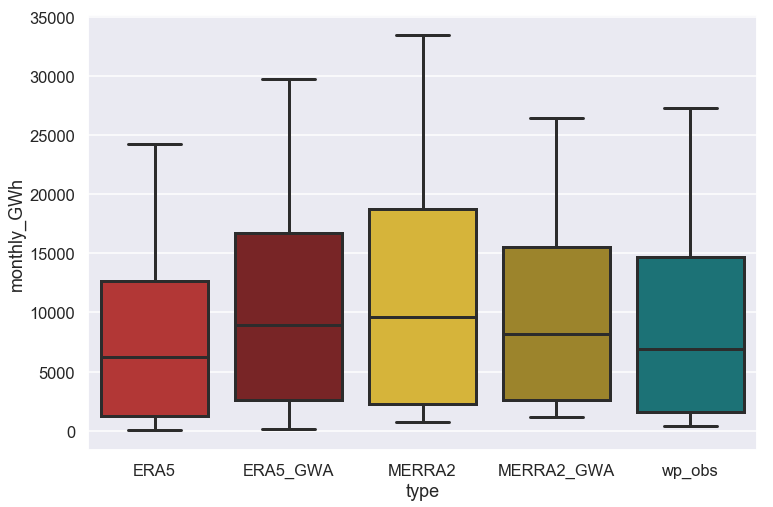

In [786]:
# plot data
plot_USAm = comp_USAm.melt(var_name='type',value_name='monthly_GWh')
sns.set(style='darkgrid',context='talk')
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='type',y='monthly_GWh',data=plot_USAm,palette=col_rf,linewidth=3)
fig = ax.get_figure()
fig.savefig(usa_path+'/results_stat/plots/absolute/USAm_abs.png')





 
# Iowa monthly
Source: same as USA

In [480]:
# extract production of Iowa
prod_IAm = pd.DataFrame({'wp_obs':prod_USAm.Iowa},
                        index = prod_USAm.index)

### Prepare simulated data

In [481]:
# load data
wp_IAE = xr.open_dataset(usa_path+"/results/windpower_states_ERA5.nc").sel({'state':"IA"}).to_dataframe().drop('state',axis=1)
wp_IAE_GWA = xr.open_dataset(usa_path+"/results/windpower_states_ERA5_GWA.nc").sel({'state':"IA"}).to_dataframe().drop('state',axis=1)
wp_IAM = xr.open_dataset(usa_path+"/results/windpower_states_MERRA2.nc").sel({'state':"IA"}).to_dataframe().drop('state',axis=1)
wp_IAM_GWA = xr.open_dataset(usa_path+"/results/windpower_states_MERRA2_GWA.nc").sel({'state':"IA"}).to_dataframe().drop('state',axis=1)

# merge data
wp_IAh = pd.concat([wp_IAE,wp_IAE_GWA,wp_IAM,wp_IAM_GWA],axis=1)
wp_IAh.columns = ['ERA5','ERA5_GWA','MERRA2','MERRA2_GWA']

# kW -> GW
wp_IAh = wp_IAh/10**6

# extract months
wp_IAh['yearmonth'] = wp_IAh.index.values.astype('datetime64[M]')
# aggregate per month
comp_IAm = wp_IAh.groupby('yearmonth').sum()
# remove yearmonth column
wp_IAh.drop('yearmonth',axis=1,inplace=True)

# add production data
comp_IAm = pd.concat([comp_IAm,prod_IAm.wp_obs],axis=1)

### Analyse

In [595]:
stats_IAm = pd.DataFrame({'ERA5':stats(comp_IAm.ERA5,comp_IAm.wp_obs),
                          'ERA5_GWA':stats(comp_IAm.ERA5_GWA,comp_IAm.wp_obs),
                          'MERRA2':stats(comp_IAm.MERRA2,comp_IAm.wp_obs),
                          'MERRA2_GWA':stats(comp_IAm.MERRA2_GWA,comp_IAm.wp_obs),
                          'obs':[np.nan,np.nan,np.nan,round(comp_IAm.wp_obs.mean(),2)]},
                         index = ['cor','rmse','mbe','avg'])

In [471]:
stats_IAm

,ERA5,ERA5_GWA,MERRA2,MERRA2_GWA,obs
cor,0.92,0.93,0.94,0.93,NaN
rmse,267.62,298.41,470.99,266.37,NaN
mbe,-4.53,107.84,322.31,-49.86,NaN
avg,782.41,894.79,1109.25,737.08,786.94


In [444]:
# save statistical results
stats_IAm.to_csv(usa_path+'/results_stat/stats_IAm_abs.csv',sep=';')

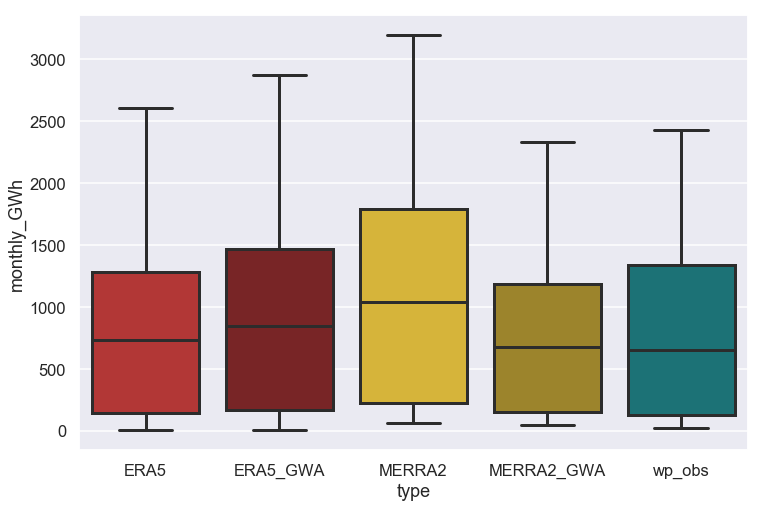

In [445]:
# plot data
plot_IAm = comp_IAm.melt(var_name='type',value_name='monthly_GWh')
sns.set(style='darkgrid',context='talk')
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='type',y='monthly_GWh',data=plot_IAm,palette=col_rf,linewidth=3)
fig = ax.get_figure()
fig.savefig(usa_path+'/results_stat/plots/absolute/IAm_abs.png')





 
# Texas monthly
Source: same as USA

In [482]:
# extract production of Texas
prod_TXm = pd.DataFrame({'wp_obs':prod_USAm.Texas},
                        index = prod_USAm.index)

### Prepare simulated data

In [483]:
# load data
wp_TXE = xr.open_dataset(usa_path+"/results/windpower_states_ERA5.nc").sel({'state':"TX"}).to_dataframe().drop('state',axis=1)
wp_TXE_GWA = xr.open_dataset(usa_path+"/results/windpower_states_ERA5_GWA.nc").sel({'state':"TX"}).to_dataframe().drop('state',axis=1)
wp_TXM = xr.open_dataset(usa_path+"/results/windpower_states_MERRA2.nc").sel({'state':"TX"}).to_dataframe().drop('state',axis=1)
wp_TXM_GWA = xr.open_dataset(usa_path+"/results/windpower_states_MERRA2_GWA.nc").sel({'state':"TX"}).to_dataframe().drop('state',axis=1)

# merge data
wp_TXh = pd.concat([wp_TXE,wp_TXE_GWA,wp_TXM,wp_TXM_GWA],axis=1)
wp_TXh.columns = ['ERA5','ERA5_GWA','MERRA2','MERRA2_GWA']

# kW -> GW
wp_TXh = wp_TXh/10**6

# extract months
wp_TXh['yearmonth'] = wp_TXh.index.values.astype('datetime64[M]')
# aggregate per month
comp_TXm = wp_TXh.groupby('yearmonth').sum()
# remove yearmonth column
wp_TXh.drop('yearmonth',axis=1,inplace=True)

# add production data
comp_TXm = pd.concat([comp_TXm,prod_TXm.wp_obs],axis=1)

### Analyse

In [596]:
stats_TXm = pd.DataFrame({'ERA5':stats(comp_TXm.ERA5,comp_TXm.wp_obs),
                          'ERA5_GWA':stats(comp_TXm.ERA5_GWA,comp_TXm.wp_obs),
                          'MERRA2':stats(comp_TXm.MERRA2,comp_TXm.wp_obs),
                          'MERRA2_GWA':stats(comp_TXm.MERRA2_GWA,comp_TXm.wp_obs),
                          'obs':[np.nan,np.nan,np.nan,round(comp_TXm.wp_obs.mean(),2)]},
                         index = ['cor','rmse','mbe','avg'])

In [468]:
# save statistical results
stats_TXm.to_csv(usa_path+'/results_stat/stats_TXm_abs.csv',sep=';')

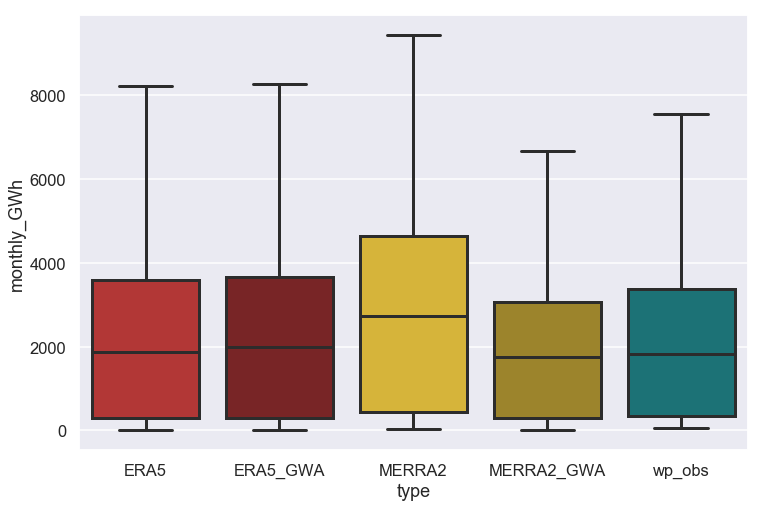

In [469]:
# plot data
plot_TXm = comp_TXm.melt(var_name='type',value_name='monthly_GWh')
sns.set(style='darkgrid',context='talk')
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='type',y='monthly_GWh',data=plot_TXm,palette=col_rf,linewidth=3)
fig = ax.get_figure()
fig.savefig(usa_path+'/results_stat/plots/absolute/TXm_abs.png')

# Texas hourly + daily

## Hourly

### Load production data
Source: http://mis.ercot.com/misapp/GetReports.do?reportTypeId=13424&reportTitle=Hourly%20Aggregated%20Wind%20Output&showHTMLView=&mimicKey

In [485]:
files =  os.listdir(usa_path+"/generation_data/TX_hourly")
for file in files:
    if 'prod_TXh_xl' in globals():
        prod_TXh_xl = pd.concat([prod_TXh_xl,pd.read_excel(usa_path+"/generation_data/TX_hourly/"+file,sheet_name="numbers")],axis=0)
    else:
        prod_TXh_xl = pd.read_excel(usa_path+"/generation_data/TX_hourly/"+file,sheet_name="numbers")

arrange data - get production data
and consider daylight saving time and convert timezone to UTC

In [486]:
# convert to datetime format
time = [np.datetime64(t) for t in prod_TXh_xl.Date]
# create new dataframe with windpower and time and localize it to Texas and convert to UTC
# timezone Texas: MDT and CDT (https://www.timeanddate.de/stadt/zeitzone/usa/texas)
# same as in North Dakota (https://www.timeanddate.de/stadt/zeitzone/usa/north-dakota)
prod_TXh = pd.DataFrame({'wp_obs':prod_TXh_xl['Total Wind Output, MW'].values},
                         index = time).tz_localize('America/North_Dakota/Center',ambiguous='infer').tz_convert('UTC')
# make the time a column
prod_TXh['time'] = prod_TXh.index.values
# remove duplicates
prod_TXh = prod_TXh.drop_duplicates(subset="time")
# remove the time column (not needed anymore)
prod_TXh = prod_TXh.drop('time',axis=1)
# MW -> GW
prod_TXh = prod_TXh/10**3

### Prepare simulated data

In [487]:
# load data
wp_TXE = xr.open_dataset(usa_path+"/results/windpower_states_ERA5.nc").sel({'state':"TX"}).to_dataframe().drop('state',axis=1)
wp_TXE_GWA = xr.open_dataset(usa_path+"/results/windpower_states_ERA5_GWA.nc").sel({'state':"TX"}).to_dataframe().drop('state',axis=1)
wp_TXM = xr.open_dataset(usa_path+"/results/windpower_states_MERRA2.nc").sel({'state':"TX"}).to_dataframe().drop('state',axis=1)
wp_TXM_GWA = xr.open_dataset(usa_path+"/results/windpower_states_MERRA2_GWA.nc").sel({'state':"TX"}).to_dataframe().drop('state',axis=1)

# merge data
comp_TXh = pd.concat([wp_TXE,wp_TXE_GWA,wp_TXM,wp_TXM_GWA],axis=1)
comp_TXh.columns = ['ERA5','ERA5_GWA','MERRA2','MERRA2_GWA']

# set timezone
comp_TXh = comp_TXh.tz_localize('UTC')

# kW -> GW
comp_TXh = comp_TXh/10**6

# add production data
comp_TXh['wp_obs'] = comp_TXh.index.map(prod_TXh.wp_obs)

# remove lines with missing data(before recorded generation)
comp_TXh = comp_TXh.dropna()

### Analyse

In [597]:
stats_TXh = pd.DataFrame({'ERA5':stats(comp_TXh.ERA5,comp_TXh.wp_obs),
                          'ERA5_GWA':stats(comp_TXh.ERA5_GWA,comp_TXh.wp_obs),
                          'MERRA2':stats(comp_TXh.MERRA2,comp_TXh.wp_obs),
                          'MERRA2_GWA':stats(comp_TXh.MERRA2_GWA,comp_TXh.wp_obs),
                          'obs':[np.nan,np.nan,np.nan,round(comp_TXh.wp_obs.mean(),2)]},
                         index = ['cor','rmse','mbe','avg'])

In [473]:
stats_TXh

,ERA5,ERA5_GWA,MERRA2,MERRA2_GWA,obs
cor,0.95,0.95,0.91,0.88,NaN
rmse,1.97,2.00,3.82,2.19,NaN
mbe,0.60,0.68,2.72,-0.72,NaN
avg,7.64,7.72,9.76,6.32,7.04


In [385]:
# save statistical results
stats_TXh.to_csv(usa_path+'/results_stat/stats_TXh_abs.csv',sep=';')

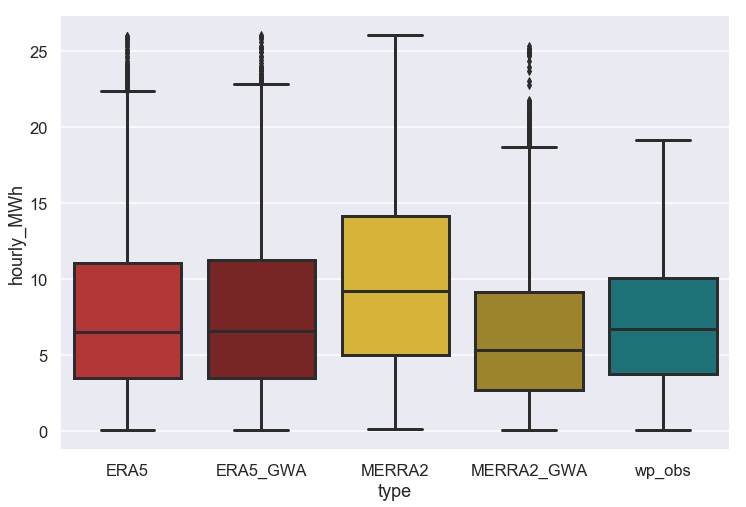

In [387]:
# plot data
plot_TXh = comp_TXh.melt(var_name='type',value_name='hourly_MWh')
sns.set(style='darkgrid',context='talk')
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='type',y='hourly_MWh',data=plot_TXh,palette=col_rf,linewidth=3)
fig = ax.get_figure()
fig.savefig(usa_path+'/results_stat/plots/absolute/TXh_abs.png')

## Daily

### Prepare data

In [488]:
# extract days
comp_TXh['yearmonthday'] = comp_TXh.index.values.astype('datetime64[D]')
# aggregate per day
comp_TXd = comp_TXh.groupby('yearmonthday').sum()
# remove first day because it has less hours
comp_TXd = comp_TXd[1:]
# remove yearmonthday column
comp_TXh.drop('yearmonthday',axis=1,inplace=True)

### Analyse

In [598]:
stats_TXd = pd.DataFrame({'ERA5':stats(comp_TXd.ERA5,comp_TXd.wp_obs),
                          'ERA5_GWA':stats(comp_TXd.ERA5_GWA,comp_TXd.wp_obs),
                          'MERRA2':stats(comp_TXd.MERRA2,comp_TXd.wp_obs),
                          'MERRA2_GWA':stats(comp_TXd.MERRA2_GWA,comp_TXd.wp_obs),
                          'obs':[np.nan,np.nan,np.nan,round(comp_TXd.wp_obs.mean(),2)]},
                         index = ['cor','rmse','mbe','avg'])

In [474]:
stats_TXd

,ERA5,ERA5_GWA,MERRA2,MERRA2_GWA,obs
cor,0.97,0.97,0.96,0.93,NaN
rmse,36.36,37.39,74.88,35.42,NaN
mbe,14.35,16.29,65.40,-17.30,NaN
avg,183.34,185.28,234.39,151.69,168.99


In [408]:
# save statistical results
stats_TXd.to_csv(usa_path+'/results_stat/stats_TXd_abs.csv',sep=';')

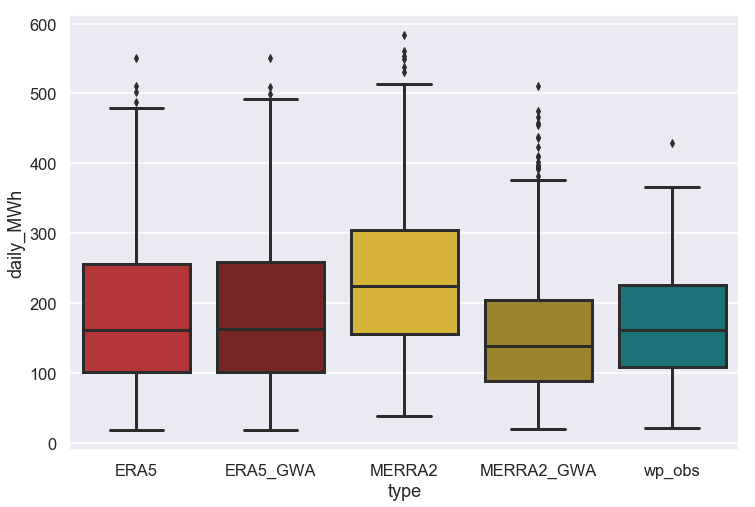

In [409]:
# plot data
plot_TXd = comp_TXd.melt(var_name='type',value_name='daily_MWh')
sns.set(style='darkgrid',context='talk')
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='type',y='daily_MWh',data=plot_TXd,palette=col_rf,linewidth=3)
fig = ax.get_figure()
fig.savefig(usa_path+'/results_stat/plots/absolute/TXd_abs.png')

# BPA hourly + daily + monthly

### Load production data
Source: https://transmission.bpa.gov/Business/Operations/Wind/  
arrange data - get production data
and consider daylight saving time and convert timezone to UTC

In [162]:
# for years 2007 to 2010 files are not formatted equally, so define columns to select
col = pd.DataFrame({'dat1':[2,2,3,3],
                    'dat2':[10,11,12,12],
                    'time1':[1,1,1,1],
                    'time2':[9,10,10,10],
                    'lines':[14,16,16,16]},
                   index = ['07','08','09','10'])
# for years 2011 to 2019 only lines are different
lines = pd.DataFrame({'x': [18,18,18,18,18,18,21,19,19]},
                     index = [11,12,13,14,15,16,17,18,19])

for year in ['07','08','09']:
    BPAxl = pd.read_excel(usa_path+"/generation_data/BPA_5min/TotalWindLoad_5Min_"+year+".xls",
                          skiprows=col.lines[year])
    # for first half of year less rows - drop them
    BPAxl_drop = BPAxl.dropna(subset=[BPAxl.columns[1]],axis=0)
    # merge data for first and second half of year in datetime indexed data frame
    BPAxl_dat = pd.DataFrame({'wp_obs':pd.concat([BPAxl_drop.iloc[:,col.dat1[year]],
                                                  BPAxl.iloc[:,col.dat2[year]]]).values},
                             index = pd.concat([pd.to_datetime(BPAxl_drop.iloc[:,col.time1[year]]),
                                                pd.to_datetime(BPAxl.iloc[:,col.time2[year]])]).values)
    # there seems to be some numeric error, therefore round index to minutes
    BPAxl_dat.index = BPAxl_dat.index.round("Min")
    
    # add the timezone and interpolate missing data (a few minutes are missing)
    #   create a dataframe with 5 minute timesteps to match values
    #   this is necessary, as there is lines for hours omitted due to daylight saving
    #   but no additional hours due to duplication of an hour in daylight saving in the second half of the year
    #   therefore the ambiguous argument 'infer' does not work
    #   by mapping the values of this hour are duplicated and then infer works
    ind = pd.date_range(start='1/1/20'+year+' 00:00:00',
                        end='31/12/20'+year+' 23:59:00', freq='5min',tz="US/Pacific")
    ind2 = [i.replace(tzinfo=None) for i in ind]
    BPAdat = pd.DataFrame({'wp_obs':np.nan},
                          index = ind2)
    BPAdat.wp_obs = BPAdat.index.map(BPAxl_dat.wp_obs)
    BPAtz = BPAdat.tz_localize('US/Pacific',ambiguous='infer').interpolate()
    # concatenate years
    if 'prod_BPA5min' in globals():
        prod_BPA5min = pd.concat([prod_BPA5min,BPAtz],axis=0)
    else:
        prod_BPA5min = BPAtz

# year 2010 is the only of the first set of years that actually has data for the duplicate hour
# therefore needs to be handled differently
year = '10'
BPAxl = pd.read_excel(usa_path+"/generation_data/BPA_5min/TotalWindLoad_5Min_"+year+".xls",
                      skiprows=col.lines[year])
BPAxl_drop = BPAxl.dropna(subset=[BPAxl.columns[1]],axis=0)
BPAxl_dat = pd.DataFrame({'wp_obs':pd.concat([BPAxl_drop.iloc[:,col.dat1[year]],
                                              BPAxl.iloc[:,col.dat2[year]]]).values},
                         index = pd.concat([pd.to_datetime(BPAxl_drop.iloc[:,col.time1[year]]),
                                            pd.to_datetime(BPAxl.iloc[:,col.time2[year]])]).values)
BPAtz = BPAxl_dat.tz_localize('US/Pacific',ambiguous='infer').interpolate()
prod_BPA5min = pd.concat([prod_BPA5min,BPAtz],axis=0)

for year in range(11,19):
    # read data from two sheets separately
    BPAxl1 = pd.read_excel(usa_path+"/generation_data/BPA_5min/WindGenTotalLoadYTD_20"+str(year)+".xls",
                           sheet_name="January-June",
                           skiprows=lines.x[year])
    BPAxl2 = pd.read_excel(usa_path+"/generation_data/BPA_5min/WindGenTotalLoadYTD_20"+str(year)+".xls",
                           sheet_name="July-December",
                           skiprows=lines.x[year])
    # merge data for first and second half of year in datetime indexed data frame
    # and add a timezone and interpolate missing values
    BPAdat = pd.DataFrame({'wp_obs':pd.concat([BPAxl1.iloc[:,2],BPAxl2.iloc[:,2]]).values},
                          index = pd.concat([pd.to_datetime(BPAxl1.iloc[:,0]),
                                             pd.to_datetime(BPAxl2.iloc[:,0])]).values
                         ).tz_localize('US/Pacific',ambiguous='infer').interpolate()
    # concatenate years
    prod_BPA5min = pd.concat([prod_BPA5min,BPAdat],axis=0)

In [163]:
# select only data of interest and convert to UTC
prod_BPA5min = prod_BPA5min[prod_BPA5min.index<pd.to_datetime("2019-01-01",utc=True)].tz_convert('UTC')

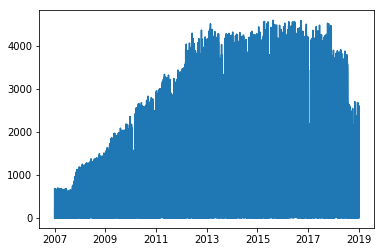

In [164]:
plt.plot(prod_BPA5min)

aggregate hourly  
divide by 12 to account for 5 minutes being 12th of hour

In [247]:
hours = prod_BPA5min.index.values.astype('datetime64[h]')
prod_BPAh = prod_BPA5min.groupby(hours).sum().tz_localize("UTC")/12

### Prepare simulated data

In [720]:
# load data
wp_BPAE = xr.open_dataset(usa_path+"/results/windpower_BPA_ERA5.nc").to_dataframe()
wp_BPAE_GWA = xr.open_dataset(usa_path+"/results/windpower_BPA_ERA5_GWA.nc").to_dataframe()
wp_BPAM = xr.open_dataset(usa_path+"/results/windpower_BPA_MERRA2.nc").to_dataframe()
wp_BPAM_GWA = xr.open_dataset(usa_path+"/results/windpower_BPA_MERRA2_GWA.nc").to_dataframe()

# merge data
comp_BPAh = pd.concat([wp_BPAE,wp_BPAE_GWA,wp_BPAM,wp_BPAM_GWA],axis=1)
comp_BPAh.columns = ['ERA5','ERA5_GWA','MERRA2','MERRA2_GWA']

# set timezone
comp_BPAh = comp_BPAh.tz_localize('UTC')

# cut at 2007 (where production starts)
comp_BPAh = comp_BPAh[comp_BPAh.index.values>=np.datetime64("2007-01-01 00:00:00")]

# kW -> MW
comp_BPAh = comp_BPAh/10**3

# add production data
comp_BPAh['wp_obs'] = comp_BPAh.index.map(prod_BPAh.wp_obs)

# fill lines with missing data(before recorded generation) with 0, because 0 generation in first hours
# won't make a difference if add a few more 0s
comp_BPAh = comp_BPAh.fillna(0)

# MW -> GW
comp_BPAh = comp_BPAh/10**3

## Hourly

### Analyse

In [721]:
stats_BPAh = pd.DataFrame({'ERA5':stats(comp_BPAh.ERA5,comp_BPAh.wp_obs),
                           'ERA5_GWA':stats(comp_BPAh.ERA5_GWA,comp_BPAh.wp_obs),
                           'MERRA2':stats(comp_BPAh.MERRA2,comp_BPAh.wp_obs),
                           'MERRA2_GWA':stats(comp_BPAh.MERRA2_GWA,comp_BPAh.wp_obs),
                           'obs':[np.nan,np.nan,np.nan,round(comp_BPAh.wp_obs.mean(),2)]},
                          index = ['cor','rmse','mbe','avg'])

In [722]:
stats_BPAh

,ERA5,ERA5_GWA,MERRA2,MERRA2_GWA,obs
cor,0.87,0.92,0.72,0.70,NaN
rmse,0.64,0.46,0.88,0.82,NaN
mbe,-0.35,0.03,0.21,-0.03,NaN
avg,0.60,0.99,1.16,0.92,0.95


In [723]:
# save statistical results
stats_BPAh.to_csv(usa_path+'/results_stat/stats_BPAh_abs.csv',sep=';')

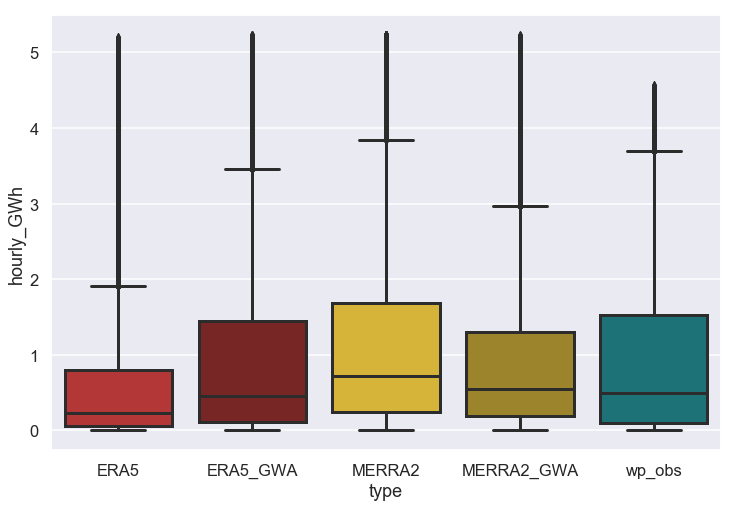

In [724]:
# plot data
plot_BPAh = comp_BPAh.melt(var_name='type',value_name='hourly_GWh')
sns.set(style='darkgrid',context='talk')
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='type',y='hourly_GWh',data=plot_BPAh,palette=col_rf,linewidth=3)
fig = ax.get_figure()
fig.savefig(usa_path+'/results_stat/plots/absolute/BPAh_abs.png')

## Daily

aggregate daily

In [725]:
days = comp_BPAh.index.values.astype('datetime64[D]')
comp_BPAd = comp_BPAh.groupby(days).sum()

### Analyse

In [726]:
stats_BPAd = pd.DataFrame({'ERA5':stats(comp_BPAd.ERA5,comp_BPAd.wp_obs),
                           'ERA5_GWA':stats(comp_BPAd.ERA5_GWA,comp_BPAd.wp_obs),
                           'MERRA2':stats(comp_BPAd.MERRA2,comp_BPAd.wp_obs),
                           'MERRA2_GWA':stats(comp_BPAd.MERRA2_GWA,comp_BPAd.wp_obs),
                           'obs':[np.nan,np.nan,np.nan,round(comp_BPAd.wp_obs.mean(),2)]},
                          index = ['cor','rmse','mbe','avg'])

In [727]:
stats_BPAd

,ERA5,ERA5_GWA,MERRA2,MERRA2_GWA,obs
cor,0.90,0.94,0.75,0.72,NaN
rmse,13.04,8.06,17.07,15.86,NaN
mbe,-8.40,0.79,4.92,-0.74,NaN
avg,14.52,23.70,27.83,22.17,22.91


In [728]:
# save statistical results
stats_BPAd.to_csv(usa_path+'/results_stat/stats_BPAd_abs.csv',sep=';')

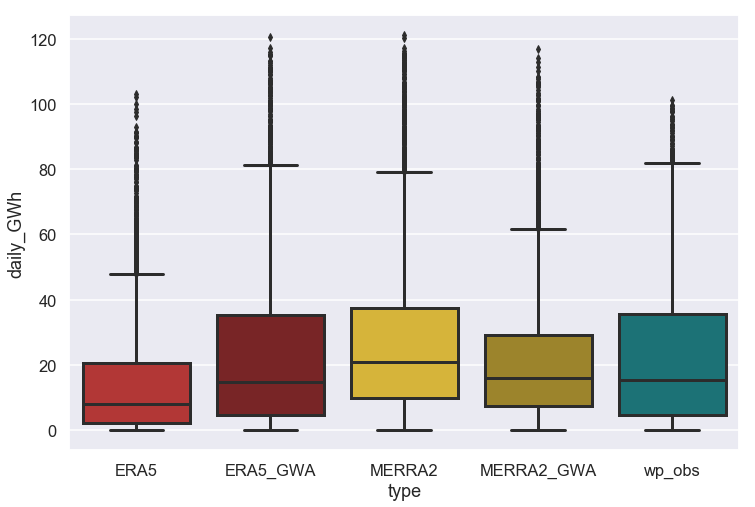

In [729]:
# plot data
plot_BPAd = comp_BPAd.melt(var_name='type',value_name='daily_GWh')
sns.set(style='darkgrid',context='talk')
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='type',y='daily_GWh',data=plot_BPAd,palette=col_rf,linewidth=3)
fig = ax.get_figure()
fig.savefig(usa_path+'/results_stat/plots/absolute/BPAd_abs.png')

## Monthly

aggregate monthly

In [730]:
months = comp_BPAh.index.values.astype('datetime64[M]')
comp_BPAm = comp_BPAh.groupby(months).sum()

### Analyse

In [731]:
stats_BPAm = pd.DataFrame({'ERA5':stats(comp_BPAm.ERA5,comp_BPAm.wp_obs),
                           'ERA5_GWA':stats(comp_BPAm.ERA5_GWA,comp_BPAm.wp_obs),
                           'MERRA2':stats(comp_BPAm.MERRA2,comp_BPAm.wp_obs),
                           'MERRA2_GWA':stats(comp_BPAm.MERRA2_GWA,comp_BPAm.wp_obs),
                           'obs':[np.nan,np.nan,np.nan,round(comp_BPAm.wp_obs.mean(),2)]},
                          index = ['cor','rmse','mbe','avg'])

In [732]:
stats_BPAm

,ERA5,ERA5_GWA,MERRA2,MERRA2_GWA,obs
cor,0.88,0.93,0.62,0.58,NaN
rmse,309.89,121.85,345.84,289.86,NaN
mbe,-255.53,24.03,149.82,-22.62,NaN
avg,441.83,721.38,847.18,674.73,697.36


In [733]:
# save statistical results
stats_BPAm.to_csv(usa_path+'/results_stat/stats_BPAm_abs.csv',sep=';')

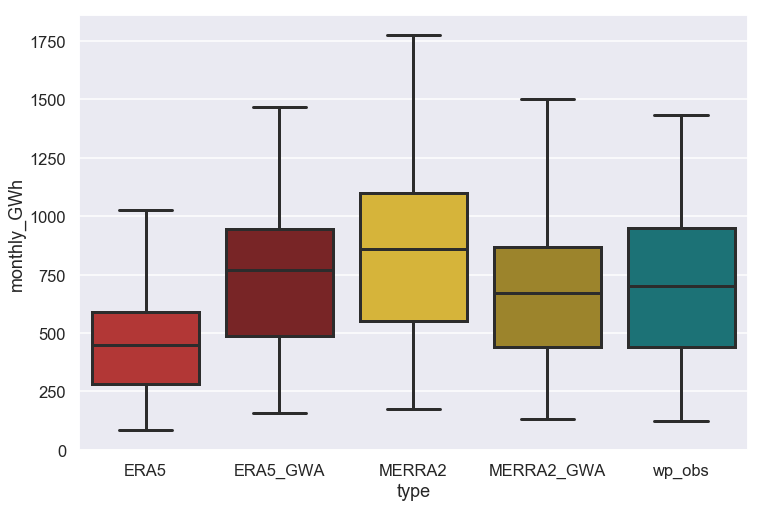

In [734]:
# plot data
plot_BPAm = comp_BPAm.melt(var_name='type',value_name='monthly_GWh')
sns.set(style='darkgrid',context='talk')
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='type',y='monthly_GWh',data=plot_BPAm,palette=col_rf,linewidth=3)
fig = ax.get_figure()
fig.savefig(usa_path+'/results_stat/plots/absolute/BPAm_abs.png')

# New England monthly

### Load production data
Source: https://www.iso-ne.com/isoexpress/web/reports/load-and-demand/-/tree/sys-load-eei-fmt

In [459]:
del(windally)

In [460]:
# years 2000 - 2015 in one file
for year in range(2000,2016):
    NExl = pd.read_excel(usa_path+"/generation_data/NewEngland_monthly/2000-2015_energy_peak_source.xls",
                         sheet_name = str(year))
    windy = NExl.iloc[np.where(NExl.iloc[:,0]=='Wind')[0][0]][2:14].values
    if 'windally' in globals():
        windally = windally + list(windy)
    else:
        windally = list(windy)

for year in range(2016,2019):
    NExl = pd.read_excel(usa_path+"/generation_data/NewEngland_monthly/"+str(year)+"_energy_peak_by_source.xlsx",
                         sheet_name = str(year))
    windy = NExl.iloc[np.where(NExl.iloc[:,0]=='WIND')[0][0]][1:13].values
    windally = windally + list(windy)
    
prod_NE = pd.DataFrame({'wp_obs':windally},
                       index = pd.date_range(start='01-01-2000',
                                             end='01-01-2019',
                                             freq='m').values.astype('datetime64[M]').astype('datetime64[s]'))# type of index is changed to get beginning of month


### Prepare simulated data

In [471]:
# load data
wp_NEE = xr.open_dataset(usa_path+"/results/windpower_NewEngland_ERA5.nc").to_dataframe()
wp_NEE_GWA = xr.open_dataset(usa_path+"/results/windpower_NewEngland_ERA5_GWA.nc").to_dataframe()
wp_NEM = xr.open_dataset(usa_path+"/results/windpower_NewEngland_MERRA2.nc").to_dataframe()
wp_NEM_GWA = xr.open_dataset(usa_path+"/results/windpower_NewEngland_MERRA2_GWA.nc").to_dataframe()

# merge data
comp_NEh = pd.concat([wp_NEE,wp_NEE_GWA,wp_NEM,wp_NEM_GWA],axis=1)
comp_NEh.columns = ['ERA5','ERA5_GWA','MERRA2','MERRA2_GWA']

# cut at 2006 (where production starts)
comp_NEh = comp_NEh[comp_NEh.index.values>=np.datetime64("2006-01-01 00:00:00")]

# aggregate monthly
comp_NEm = comp_NEh.groupby(comp_NEh.index.values.astype('datetime64[M]')).sum()

# kW -> GW
comp_NEm = comp_NEm/10**6

# add production data
comp_NEm['wp_obs'] = comp_NEm.index.map(prod_NE.wp_obs)

### Analyse

In [475]:
stats_NEm = pd.DataFrame({'ERA5':stats(comp_NEm.ERA5,comp_NEm.wp_obs),
                          'ERA5_GWA':stats(comp_NEm.ERA5_GWA,comp_NEm.wp_obs),
                          'MERRA2':stats(comp_NEm.MERRA2,comp_NEm.wp_obs),
                          'MERRA2_GWA':stats(comp_NEm.MERRA2_GWA,comp_NEm.wp_obs),
                          'obs':[np.nan,np.nan,np.nan,round(comp_NEm.wp_obs.mean(),2)]},
                          index = ['cor','rmse','mbe','avg'])

In [476]:
stats_NEm

,ERA5,ERA5_GWA,MERRA2,MERRA2_GWA,obs
cor,0.98,0.99,0.97,0.98,NaN
rmse,37.98,81.88,30.29,109.00,NaN
mbe,-23.62,65.14,-14.88,87.00,NaN
avg,90.16,178.92,98.90,200.78,113.78


In [364]:
# save statistical results
stats_NEm.to_csv(usa_path+'/results_stat/stats_NEm_abs.csv',sep=';')

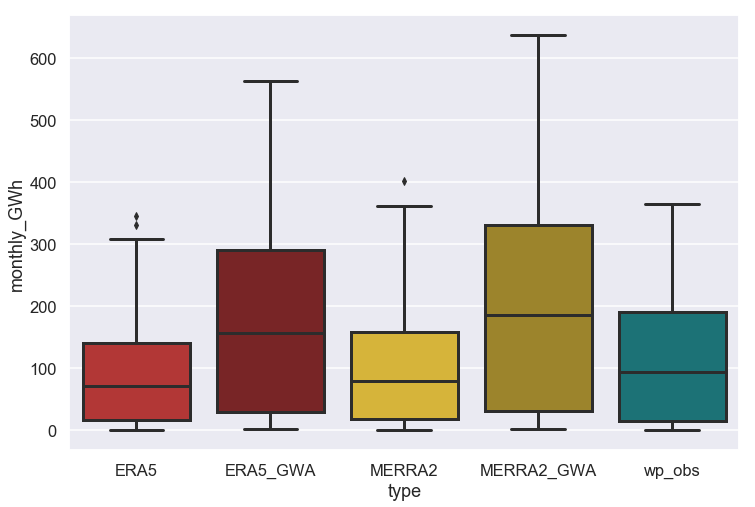

In [477]:
# plot data
plot_NEm = comp_NEm.melt(var_name='type',value_name='monthly_GWh')
sns.set(style='darkgrid',context='talk')
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='type',y='monthly_GWh',data=plot_NEm,palette=col_rf,linewidth=3)
fig = ax.get_figure()
fig.savefig(usa_path+'/results_stat/plots/absolute/NEm_abs.png')

# Installed Capacities

### Prepare wind park data

In [276]:
windturbines = pd.read_csv(usa_path+"/windturbines_usa.csv",delimiter=';') 

In [277]:
# 0.1% of years are missing, so set them mean of commissioning years
y = windturbines.p_year.fillna(windturbines.p_year.mean())

In [278]:
# capacities
cap = windturbines.t_cap.fillna(1700)

In [279]:
# hub heights
hh = windturbines.t_hh.fillna(80)

make commissioning dates - only years given so use middle of year

In [280]:
t = [np.datetime64(str(int(year))+"-06-01T00:00:00") for year in y]

### make time series and get mean capacities

create time series of installed capacities

In [284]:
# sort installed capacities by commissioning date
com = pd.DataFrame({'capacity': cap.values,'region': windturbines.t_state.values},index=t)
com = com.sort_index()

In [286]:
# cumulative capacity USA
cap_usa = com
cap_usa = cap_usa.drop(columns={'region'}).groupby(cap_usa.index).sum()
cap_usa['capsum'] = cap_usa.capacity.cumsum()

In [290]:
# cumulative capacity Iowa
cap_IA = com[com.region=='IA']
cap_IA = cap_IA.drop(columns={'region'}).groupby(cap_IA.index).sum()
cap_IA['capsum'] = cap_IA.capacity.cumsum()

In [292]:
# cumulative capacity Texas
cap_TX = com[com.region=='TX']
cap_TX = cap_TX.drop(columns={'region'}).groupby(cap_TX.index).sum()
cap_TX['capsum'] = cap_TX.capacity.cumsum()

In [327]:
# cumulative capacity BPA
# new commissioning with park names
com2 = pd.DataFrame({'capacity': cap.values,
                     'region': windturbines.t_state.values,
                     'name': windturbines.p_name.values},index=t)
com2 = com2.sort_index()
# load wind parks of BPA
BPA_parks = pd.read_csv(usa_path+"/BPA_windparks.csv")
# find those parks in wind turbine data
ind = [park in BPA_parks.name.values for park in com2.name.values]

cap_BPA = pd.DataFrame(com2.iloc[ind,0])
cap_BPA = cap_BPA.groupby(cap_BPA.index).sum()
cap_BPA['capsum'] = cap_BPA.capacity.cumsum()

In [302]:
# cumulative capacity New England
NE_states = ['CT','NH','ME','MA','RI','VT']
cap_NE = com[com.region.isin(NE_states)]
cap_NE = cap_NE.drop(columns={'region'}).groupby(cap_NE.index).sum()
cap_NE['capsum'] = cap_NE.capacity.cumsum()

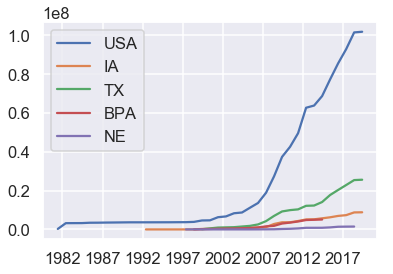

In [331]:
plt.plot(cap_usa.capsum)
plt.plot(cap_IA.capsum)
plt.plot(cap_TX.capsum)
plt.plot(cap_BPA.capsum)
plt.plot(cap_NE.capsum)
plt.legend(['USA','IA','TX','BPA','NE'])

get first capacity in period of interest

In [499]:
firstcap_usa = cap_usa[cap_usa.index<comp_USAm.index[0]].capsum[-1]
firstcap_IA = cap_IA[cap_IA.index<comp_IAm.index[0]].capsum[-1]
firstcap_TXm = cap_TX[cap_TX.index<comp_TXm.index[0]].capsum[-1]
firstcap_TXhd = cap_TX[cap_TX.index<comp_TXh.index[0].replace(tzinfo=None)].capsum[-1]
firstcap_BPA = cap_BPA[cap_BPA.index<comp_BPAh.index[0].replace(tzinfo=None)].capsum[-1]
firstcap_NE = cap_NE[cap_NE.index<comp_NEm.index[0]].capsum[-1]

cut capacities after starting date of production

In [511]:
capc_usa = cap_usa[(cap_usa.index>=comp_USAm.index[0])&(cap_usa.index<=comp_USAm.index[-1])]
capc_IA = cap_IA[(cap_IA.index>=comp_IAm.index[0])&(cap_IA.index<=comp_IAm.index[-1])]
capc_TXm = cap_TX[(cap_TX.index>=comp_TXm.index[0])&(cap_TX.index<=comp_TXm.index[-1])]
capc_TXhd = cap_TX[(cap_TX.index>=comp_TXh.index[0].replace(tzinfo=None))&(cap_TX.index<=comp_TXh.index[-1].replace(tzinfo=None))]
capc_BPA = cap_BPA[(cap_BPA.index>=comp_BPAh.index[0].replace(tzinfo=None))&(cap_BPA.index<=comp_BPAh.index[-1].replace(tzinfo=None))]
capc_NE = cap_NE[(cap_NE.index>=comp_NEm.index[0])&(cap_NE.index<=comp_NEm.index[-1])]

Make dataframe with dates where all data are available as index to fill in capacities and then fill in data

In [579]:
# prepare dataframes
cap_usam = pd.DataFrame({'cap':0}, index = comp_USAm.index)
cap_IAm = pd.DataFrame({'cap':0}, index = comp_IAm.index)
cap_TXm = pd.DataFrame({'cap':0}, index = comp_TXm.index)
cap_TXd = pd.DataFrame({'cap':0}, index = comp_TXd.index)
cap_TXh = pd.DataFrame({'cap':0}, index = comp_TXh.index).tz_localize(None)
cap_BPAm = pd.DataFrame({'cap':0}, index = comp_BPAm.index)
cap_BPAd = pd.DataFrame({'cap':0}, index = comp_BPAd.index)
cap_BPAh = pd.DataFrame({'cap':0}, index = comp_BPAh.index).tz_localize(None)
cap_NEm = pd.DataFrame({'cap':0}, index = comp_NEm.index)

In [580]:
# fill in cumulative capacities
cap_usam.cap = cap_usam.index.map(capc_usa.capsum)
cap_IAm.cap = cap_IAm.index.map(capc_IA.capsum)
cap_TXm.cap = cap_TXm.index.map(capc_TXm.capsum)
cap_TXd.cap = cap_TXd.index.map(capc_TXhd.capsum)
cap_TXh.cap = cap_TXh.index.map(capc_TXhd.capsum)
cap_BPAm.cap = cap_BPAm.index.map(capc_BPA.capsum)
cap_BPAd.cap = cap_BPAd.index.map(capc_BPA.capsum)
cap_BPAh.cap = cap_BPAh.index.map(capc_BPA.capsum)
cap_NEm.cap = cap_NEm.index.map(capc_NE.capsum)

In [581]:
# fill in starting capacities at date of first observed generation
cap_usam.cap[0] = firstcap_usa
cap_IAm.cap[0] = firstcap_IA
cap_TXm.cap[0] = firstcap_TXm
cap_TXd.cap[0] = firstcap_TXhd
cap_TXh.cap[0] = firstcap_TXhd
cap_BPAm.cap[0] = firstcap_BPA
cap_BPAd.cap[0] = firstcap_BPA
cap_BPAh.cap[0] = firstcap_BPA
cap_NEm.cap[0] = firstcap_NE

In [582]:
# fill Nas with last capacity
cap_usam.cap = cap_usam.fillna(method='ffill')
cap_IAm.cap = cap_IAm.fillna(method='ffill')
cap_TXm.cap = cap_TXm.fillna(method='ffill')
cap_TXd.cap = cap_TXd.fillna(method='ffill')
cap_TXh.cap = cap_TXh.fillna(method='ffill')
cap_BPAm.cap = cap_BPAm.fillna(method='ffill')
cap_BPAd.cap = cap_BPAd.fillna(method='ffill')
cap_BPAh.cap = cap_BPAh.fillna(method='ffill')
cap_NEm.cap = cap_NEm.fillna(method='ffill')

#### Plot of monthly capacities

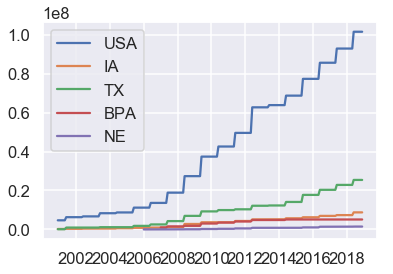

In [583]:
plt.plot(cap_usam)
plt.plot(cap_IAm)
plt.plot(cap_TXm)
plt.plot(cap_BPAm)
plt.plot(cap_NEm)
plt.legend(['USA','IA','TX','BPA','NE'])

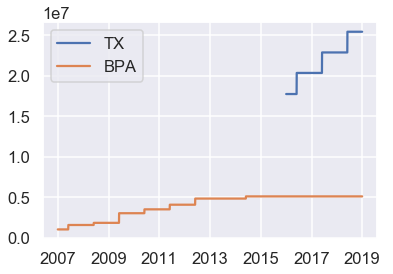

In [584]:
plt.plot(cap_TXd)
plt.plot(cap_BPAd)
plt.legend(['TX','BPA'])

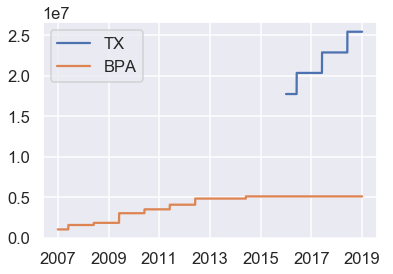

In [585]:
plt.plot(cap_TXh)
plt.plot(cap_BPAh)
plt.legend(['TX','BPA'])

In [591]:
# mean capacities
mcap_usam = cap_usam.cap.mean()/10**6
mcap_IAm = cap_IAm.cap.mean()/10**6
mcap_TXm = cap_TXm.cap.mean()/10**6
mcap_TXd = cap_TXd.cap.mean()/10**6
mcap_TXh = cap_TXh.cap.mean()/10**6
mcap_BPAm = cap_BPAm.cap.mean()/10**6
mcap_BPAd = cap_BPAd.cap.mean()/10**6
mcap_BPAh = cap_BPAh.cap.mean()/10**6
mcap_NEm = cap_NEm.cap.mean()/10**6

# Relative results

### USA

In [787]:
stats_USAmr = (stats_USAm.iloc[1:3,:4]/(mcap_usam*24*30)).round(2)
stats_USAmr

,ERA5,ERA5_GWA,MERRA2,MERRA2_GWA
rmse,0.08,0.10,0.13,0.07
mbe,-0.04,0.06,0.09,0.02


In [788]:
# save statistical results
stats_USAmr.to_csv(usa_path+'/results_stat/stats_USAm_rel.csv',sep=';')

### Iowa

In [619]:
stats_IAmr = (stats_IAm.iloc[1:3,:4]/(mcap_IAm*24*30)).round(2)
stats_IAmr

,ERA5,ERA5_GWA,MERRA2,MERRA2_GWA
rmse,0.11,0.12,0.19,0.11
mbe,-0.00,0.04,0.13,-0.02


In [620]:
# save statistical results
stats_IAmr.to_csv(usa_path+'/results_stat/stats_IAm_rel.csv',sep=';')

### Texas

#### monthly

In [621]:
stats_TXmr = (stats_TXm.iloc[1:3,:4]/(mcap_TXm*24*30)).round(2)
stats_TXmr

,ERA5,ERA5_GWA,MERRA2,MERRA2_GWA
rmse,0.11,0.11,0.17,0.11
mbe,0.01,0.02,0.11,-0.04


In [622]:
# save statistical results
stats_TXmr.to_csv(usa_path+'/results_stat/stats_TXm_rel.csv',sep=';')

#### daily

In [628]:
stats_TXdr = (stats_TXd.iloc[1:3,:4]/(mcap_TXd*24)).round(2)
stats_TXdr

,ERA5,ERA5_GWA,MERRA2,MERRA2_GWA
rmse,0.07,0.07,0.14,0.07
mbe,0.03,0.03,0.12,-0.03


In [629]:
# save statistical results
stats_TXdr.to_csv(usa_path+'/results_stat/stats_TXd_rel.csv',sep=';')

#### hourly

In [630]:
stats_TXhr = (stats_TXh.iloc[1:3,:4]/mcap_TXh).round(2)
stats_TXhr

,ERA5,ERA5_GWA,MERRA2,MERRA2_GWA
rmse,0.09,0.09,0.18,0.10
mbe,0.03,0.03,0.12,-0.03


In [631]:
# save statistical results
stats_TXhr.to_csv(usa_path+'/results_stat/stats_TXh_rel.csv',sep=';')

### BPA

#### monthly

In [735]:
stats_BPAmr = (stats_BPAm.iloc[1:3,:4]/(mcap_BPAm*24*30)).round(2)
stats_BPAmr

,ERA5,ERA5_GWA,MERRA2,MERRA2_GWA
rmse,0.11,0.04,0.12,0.10
mbe,-0.09,0.01,0.05,-0.01


In [736]:
# save statistical results
stats_BPAmr.to_csv(usa_path+'/results_stat/stats_BPAm_rel.csv',sep=';')

#### daily

In [737]:
stats_BPAdr = (stats_BPAd.iloc[1:3,:4]/(mcap_BPAd*24)).round(2)
stats_BPAdr

,ERA5,ERA5_GWA,MERRA2,MERRA2_GWA
rmse,0.14,0.08,0.18,0.17
mbe,-0.09,0.01,0.05,-0.01


In [738]:
# save statistical results
stats_BPAdr.to_csv(usa_path+'/results_stat/stats_BPAd_rel.csv',sep=';')

#### hourly

In [739]:
stats_BPAhr = (stats_BPAh.iloc[1:3,:4]/mcap_BPAh).round(2)
stats_BPAhr

,ERA5,ERA5_GWA,MERRA2,MERRA2_GWA
rmse,0.16,0.12,0.22,0.21
mbe,-0.09,0.01,0.05,-0.01


In [740]:
# save statistical results
stats_BPAhr.to_csv(usa_path+'/results_stat/stats_BPAh_rel.csv',sep=';')

### New England

In [625]:
stats_NEmr = (stats_NEm.iloc[1:3,:4]/(mcap_NEm*24*30)).round(2)
stats_NEmr

,ERA5,ERA5_GWA,MERRA2,MERRA2_GWA
rmse,0.08,0.18,0.06,0.23
mbe,-0.05,0.14,-0.03,0.19


In [626]:
# save statistical results
stats_NEmr.to_csv(usa_path+'/results_stat/stats_NEm_rel.csv',sep=';')

# Capacity factors

let's also calculate capacity factors

### USA

In [789]:
CF_USAm = comp_USAm.div(cap_usam.cap.values*24*30/10**6,axis=0)
stats_USAm_cf = pd.DataFrame({'ERA5':stats(CF_USAm.ERA5,CF_USAm.wp_obs),
                              'ERA5_GWA':stats(CF_USAm.ERA5_GWA,CF_USAm.wp_obs),
                              'MERRA2':stats(CF_USAm.MERRA2,CF_USAm.wp_obs),
                              'MERRA2_GWA':stats(CF_USAm.MERRA2_GWA,CF_USAm.wp_obs),
                              'obs':[np.nan,np.nan,np.nan,round(CF_USAm.wp_obs.mean(),2)]},
                             index = ['cor','rmse','mbe','avg'])
stats_USAm_cf

,ERA5,ERA5_GWA,MERRA2,MERRA2_GWA,obs
cor,0.78,0.48,0.78,0.24,NaN
rmse,0.07,0.12,0.11,0.12,NaN
mbe,-0.04,0.09,0.10,0.07,NaN
avg,0.23,0.35,0.36,0.34,0.26


In [790]:
# save statistical results
stats_USAm_cf.to_csv(usa_path+'/results_stat/stats_USAm_cf.csv',sep=';')

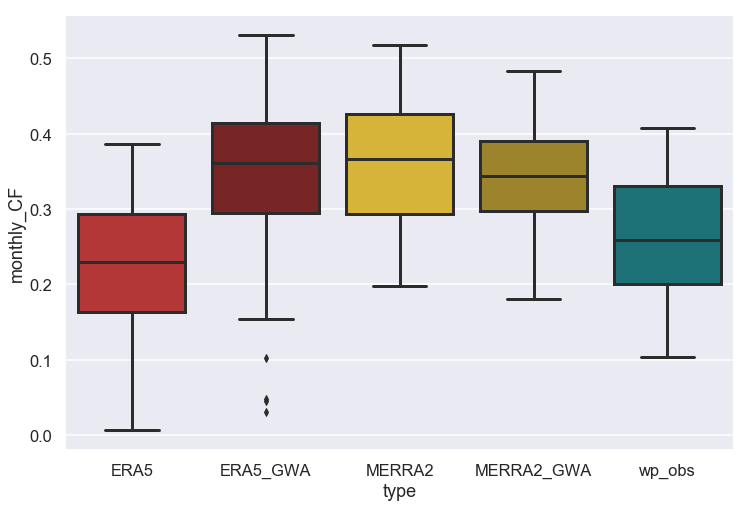

In [791]:
# plot data
plot_USAm_cf = CF_USAm.melt(var_name='type',value_name='monthly_CF')
sns.set(style='darkgrid',context='talk')
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='type',y='monthly_CF',data=plot_USAm_cf,palette=col_rf,linewidth=3)
fig = ax.get_figure()
fig.savefig(usa_path+'/results_stat/plots/CF/USAm_cf.png')

### Iowa

In [669]:
CF_IAm = comp_IAm.div(cap_IAm.cap.values*24*30/10**6,axis=0)
stats_IAm_cf = pd.DataFrame({'ERA5':stats(CF_IAm.ERA5,CF_IAm.wp_obs),
                             'ERA5_GWA':stats(CF_IAm.ERA5_GWA,CF_IAm.wp_obs),
                             'MERRA2':stats(CF_IAm.MERRA2,CF_IAm.wp_obs),
                             'MERRA2_GWA':stats(CF_IAm.MERRA2_GWA,CF_IAm.wp_obs),
                             'obs':[np.nan,np.nan,np.nan,round(CF_IAm.wp_obs.mean(),2)]},
                            index = ['cor','rmse','mbe','avg'])
stats_IAm_cf

,ERA5,ERA5_GWA,MERRA2,MERRA2_GWA,obs
cor,0.49,0.48,0.54,0.52,NaN
rmse,0.11,0.12,0.18,0.09,NaN
mbe,-0.00,0.04,0.15,0.00,NaN
avg,0.30,0.35,0.45,0.30,0.3


In [671]:
# save statistical results
stats_IAm_cf.to_csv(usa_path+'/results_stat/stats_IAm_cf.csv',sep=';')

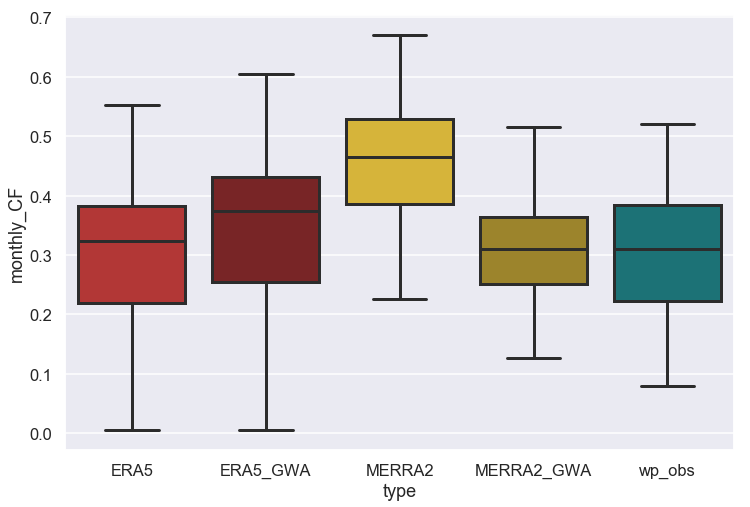

In [672]:
# plot data
plot_IAm_cf = CF_IAm.melt(var_name='type',value_name='monthly_CF')
sns.set(style='darkgrid',context='talk')
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='type',y='monthly_CF',data=plot_IAm_cf,palette=col_rf,linewidth=3)
fig = ax.get_figure()
fig.savefig(usa_path+'/results_stat/plots/CF/IAm_cf.png')

### Texas

#### monthly

In [673]:
CF_TXm = comp_TXm.div(cap_TXm.cap.values*24*30/10**6,axis=0)
stats_TXm_cf = pd.DataFrame({'ERA5':stats(CF_TXm.ERA5,CF_TXm.wp_obs),
                             'ERA5_GWA':stats(CF_TXm.ERA5_GWA,CF_TXm.wp_obs),
                             'MERRA2':stats(CF_TXm.MERRA2,CF_TXm.wp_obs),
                             'MERRA2_GWA':stats(CF_TXm.MERRA2_GWA,CF_TXm.wp_obs),
                             'obs':[np.nan,np.nan,np.nan,round(CF_TXm.wp_obs.mean(),2)]},
                            index = ['cor','rmse','mbe','avg'])
stats_TXm_cf

,ERA5,ERA5_GWA,MERRA2,MERRA2_GWA,obs
cor,0.19,0.17,0.16,0.16,NaN
rmse,0.21,0.21,0.21,0.20,NaN
mbe,-0.04,-0.03,0.08,-0.06,NaN
avg,0.31,0.33,0.44,0.30,0.36


In [674]:
# save statistical results
stats_TXm_cf.to_csv(usa_path+'/results_stat/stats_TXm_cf.csv',sep=';')

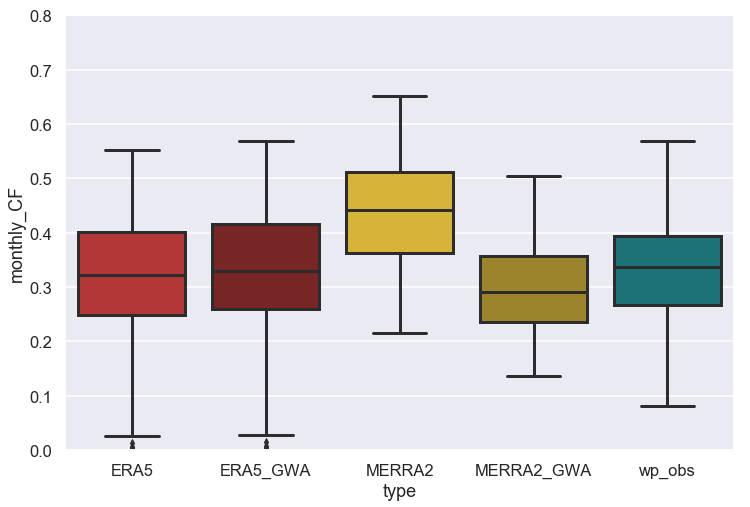

In [678]:
# plot data
plot_TXm_cf = CF_TXm.melt(var_name='type',value_name='monthly_CF')
sns.set(style='darkgrid',context='talk')
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='type',y='monthly_CF',data=plot_TXm_cf,palette=col_rf,linewidth=3)

plt.ylim(0,0.8)

fig = ax.get_figure()
fig.savefig(usa_path+'/results_stat/plots/CF/TXm_cf.png')

#### daily

In [679]:
CF_TXd = comp_TXd.div(cap_TXd.cap.values*24/10**6,axis=0)
stats_TXd_cf = pd.DataFrame({'ERA5':stats(CF_TXd.ERA5,CF_TXd.wp_obs),
                             'ERA5_GWA':stats(CF_TXd.ERA5_GWA,CF_TXd.wp_obs),
                             'MERRA2':stats(CF_TXd.MERRA2,CF_TXd.wp_obs),
                             'MERRA2_GWA':stats(CF_TXd.MERRA2_GWA,CF_TXd.wp_obs),
                             'obs':[np.nan,np.nan,np.nan,round(CF_TXd.wp_obs.mean(),2)]},
                            index = ['cor','rmse','mbe','avg'])
stats_TXd_cf

,ERA5,ERA5_GWA,MERRA2,MERRA2_GWA,obs
cor,0.97,0.97,0.96,0.93,NaN
rmse,0.07,0.07,0.14,0.07,NaN
mbe,0.03,0.03,0.13,-0.03,NaN
avg,0.35,0.36,0.45,0.29,0.33


In [680]:
# save statistical results
stats_TXd_cf.to_csv(usa_path+'/results_stat/stats_TXd_cf.csv',sep=';')

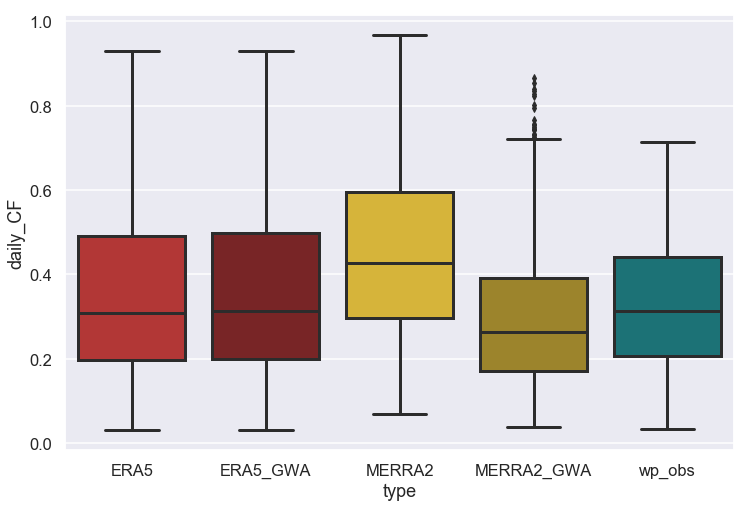

In [681]:
# plot data
plot_TXd_cf = CF_TXd.melt(var_name='type',value_name='daily_CF')
sns.set(style='darkgrid',context='talk')
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='type',y='daily_CF',data=plot_TXd_cf,palette=col_rf,linewidth=3)
fig = ax.get_figure()
fig.savefig(usa_path+'/results_stat/plots/CF/TXd_cf.png')

#### hourly

In [682]:
CF_TXh = comp_TXh.div(cap_TXh.cap.values/10**6,axis=0)
stats_TXh_cf = pd.DataFrame({'ERA5':stats(CF_TXh.ERA5,CF_TXh.wp_obs),
                             'ERA5_GWA':stats(CF_TXh.ERA5_GWA,CF_TXh.wp_obs),
                             'MERRA2':stats(CF_TXh.MERRA2,CF_TXh.wp_obs),
                             'MERRA2_GWA':stats(CF_TXh.MERRA2_GWA,CF_TXh.wp_obs),
                             'obs':[np.nan,np.nan,np.nan,round(CF_TXh.wp_obs.mean(),2)]},
                            index = ['cor','rmse','mbe','avg'])
stats_TXh_cf

,ERA5,ERA5_GWA,MERRA2,MERRA2_GWA,obs
cor,0.95,0.95,0.91,0.89,NaN
rmse,0.09,0.09,0.18,0.10,NaN
mbe,0.03,0.03,0.13,-0.03,NaN
avg,0.35,0.36,0.45,0.29,0.32


In [683]:
# save statistical results
stats_TXh_cf.to_csv(usa_path+'/results_stat/stats_TXh_cf.csv',sep=';')

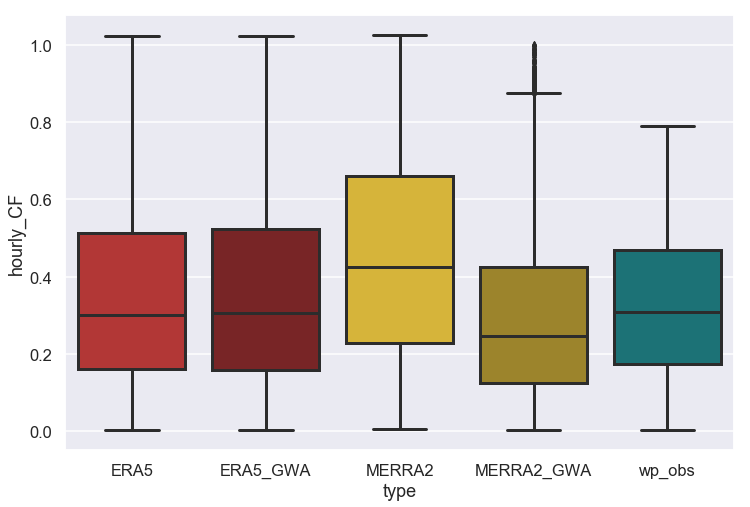

In [684]:
# plot data
plot_TXh_cf = CF_TXh.melt(var_name='type',value_name='hourly_CF')
sns.set(style='darkgrid',context='talk')
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='type',y='hourly_CF',data=plot_TXh_cf,palette=col_rf,linewidth=3)
fig = ax.get_figure()
fig.savefig(usa_path+'/results_stat/plots/CF/TXh_cf.png')

### BPA

#### monthly

In [741]:
CF_BPAm = comp_BPAm.div(cap_BPAm.cap.values*24*30/10**6,axis=0)
stats_BPAm_cf = pd.DataFrame({'ERA5':stats(CF_BPAm.ERA5,CF_BPAm.wp_obs),
                              'ERA5_GWA':stats(CF_BPAm.ERA5_GWA,CF_BPAm.wp_obs),
                              'MERRA2':stats(CF_BPAm.MERRA2,CF_BPAm.wp_obs),
                              'MERRA2_GWA':stats(CF_BPAm.MERRA2_GWA,CF_BPAm.wp_obs),
                              'obs':[np.nan,np.nan,np.nan,round(CF_BPAm.wp_obs.mean(),2)]},
                             index = ['cor','rmse','mbe','avg'])
stats_BPAm_cf

,ERA5,ERA5_GWA,MERRA2,MERRA2_GWA,obs
cor,0.76,0.85,0.18,0.17,NaN
rmse,0.10,0.04,0.11,0.09,NaN
mbe,-0.09,0.01,0.05,-0.01,NaN
avg,0.16,0.26,0.29,0.24,0.25


In [742]:
# save statistical results
stats_BPAm_cf.to_csv(usa_path+'/results_stat/stats_BPAm_cf.csv',sep=';')

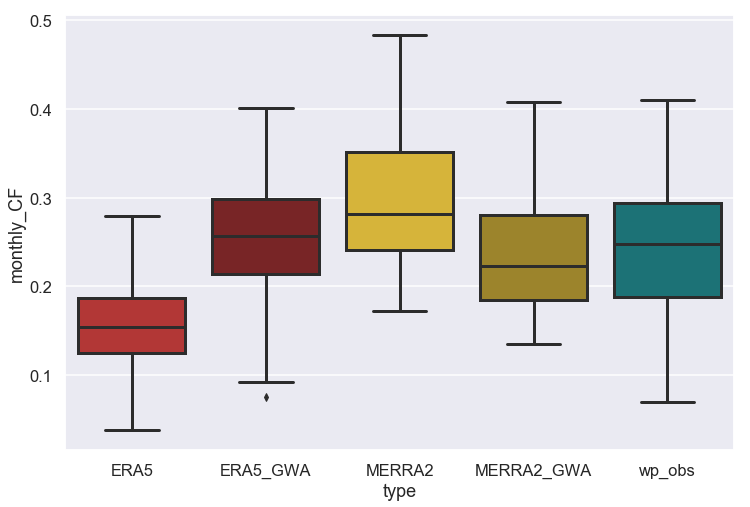

In [743]:
# plot data
plot_BPAm_cf = CF_BPAm.melt(var_name='type',value_name='monthly_CF')
sns.set(style='darkgrid',context='talk')
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='type',y='monthly_CF',data=plot_BPAm_cf,palette=col_rf,linewidth=3)
fig = ax.get_figure()
fig.savefig(usa_path+'/results_stat/plots/CF/BPAm_cf.png')

#### daily

In [744]:
CF_BPAd = comp_BPAd.div(cap_BPAd.cap.values*24/10**6,axis=0)
stats_BPAd_cf = pd.DataFrame({'ERA5':stats(CF_BPAd.ERA5,CF_BPAd.wp_obs),
                             'ERA5_GWA':stats(CF_BPAd.ERA5_GWA,CF_BPAd.wp_obs),
                             'MERRA2':stats(CF_BPAd.MERRA2,CF_BPAd.wp_obs),
                             'MERRA2_GWA':stats(CF_BPAd.MERRA2_GWA,CF_BPAd.wp_obs),
                             'obs':[np.nan,np.nan,np.nan,round(CF_BPAd.wp_obs.mean(),2)]},
                            index = ['cor','rmse','mbe','avg'])
stats_BPAd_cf

,ERA5,ERA5_GWA,MERRA2,MERRA2_GWA,obs
cor,0.89,0.93,0.72,0.70,NaN
rmse,0.13,0.09,0.16,0.15,NaN
mbe,-0.09,0.01,0.05,-0.01,NaN
avg,0.15,0.25,0.29,0.23,0.24


In [745]:
# save statistical results
stats_BPAd_cf.to_csv(usa_path+'/results_stat/stats_BPAd_cf.csv',sep=';')

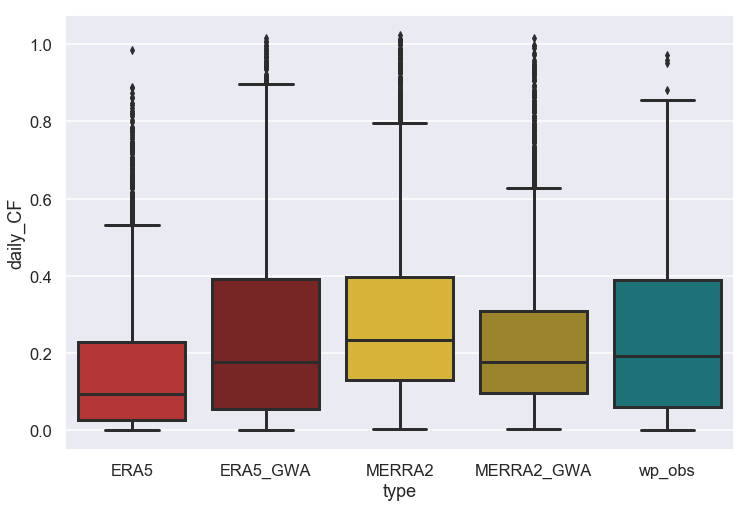

In [746]:
# plot data
plot_BPAd_cf = CF_BPAd.melt(var_name='type',value_name='daily_CF')
sns.set(style='darkgrid',context='talk')
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='type',y='daily_CF',data=plot_BPAd_cf,palette=col_rf,linewidth=3)
fig = ax.get_figure()
fig.savefig(usa_path+'/results_stat/plots/CF/BPAd_cf.png')

#### hourly

In [751]:
CF_BPAh = comp_BPAh.div(cap_BPAh.cap.values/10**6,axis=0)
stats_BPAh_cf = pd.DataFrame({'ERA5':stats(CF_BPAh.ERA5,CF_BPAh.wp_obs),
                             'ERA5_GWA':stats(CF_BPAh.ERA5_GWA,CF_BPAh.wp_obs),
                             'MERRA2':stats(CF_BPAh.MERRA2,CF_BPAh.wp_obs),
                             'MERRA2_GWA':stats(CF_BPAh.MERRA2_GWA,CF_BPAh.wp_obs),
                             'obs':[np.nan,np.nan,np.nan,round(CF_BPAh.wp_obs.mean(),2)]},
                            index = ['cor','rmse','mbe','avg'])
stats_BPAh_cf

,ERA5,ERA5_GWA,MERRA2,MERRA2_GWA,obs
cor,0.85,0.91,0.70,0.68,NaN
rmse,0.16,0.12,0.21,0.19,NaN
mbe,-0.09,0.01,0.05,-0.01,NaN
avg,0.15,0.25,0.29,0.23,0.24


In [752]:
# save statistical results
stats_BPAh_cf.to_csv(usa_path+'/results_stat/stats_BPAh_cf.csv',sep=';')

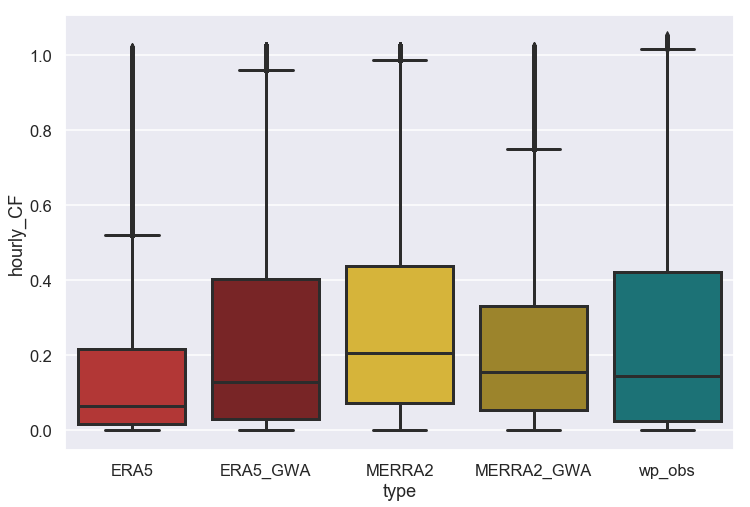

In [753]:
# plot data
plot_BPAh_cf = CF_BPAh.melt(var_name='type',value_name='hourly_CF')
sns.set(style='darkgrid',context='talk')
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='type',y='hourly_CF',data=plot_BPAh_cf,palette=col_rf,linewidth=3)
fig = ax.get_figure()
fig.savefig(usa_path+'/results_stat/plots/CF/BPAh_cf.png')

### New England

In [694]:
CF_NEm = comp_NEm.div(cap_NEm.cap.values*24*30/10**6,axis=0)
stats_NEm_cf = pd.DataFrame({'ERA5':stats(CF_NEm.ERA5,CF_NEm.wp_obs),
                              'ERA5_GWA':stats(CF_NEm.ERA5_GWA,CF_NEm.wp_obs),
                              'MERRA2':stats(CF_NEm.MERRA2,CF_NEm.wp_obs),
                              'MERRA2_GWA':stats(CF_NEm.MERRA2_GWA,CF_NEm.wp_obs),
                              'obs':[np.nan,np.nan,np.nan,round(CF_NEm.wp_obs.mean(),2)]},
                             index = ['cor','rmse','mbe','avg'])
stats_NEm_cf

,ERA5,ERA5_GWA,MERRA2,MERRA2_GWA,obs
cor,0.52,0.62,0.53,0.72,NaN
rmse,0.10,0.21,0.10,0.24,NaN
mbe,-0.00,0.18,0.02,0.22,NaN
avg,0.19,0.38,0.21,0.41,0.19


In [695]:
# save statistical results
stats_NEm_cf.to_csv(usa_path+'/results_stat/stats_NEm_cf.csv',sep=';')

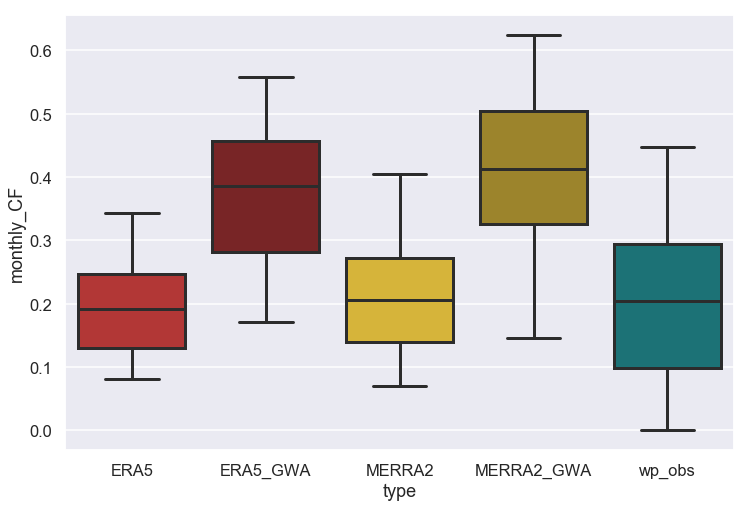

In [696]:
# plot data
plot_NEm_cf = CF_NEm.melt(var_name='type',value_name='monthly_CF')
sns.set(style='darkgrid',context='talk')
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='type',y='monthly_CF',data=plot_NEm_cf,palette=col_rf,linewidth=3)
fig = ax.get_figure()
fig.savefig(usa_path+'/results_stat/plots/CF/NEm_cf.png')